In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.io as sio 

from numpy.fft import fft, rfft
from PIL import Image

In [2]:
def EEG_extract(file):
    # Convert EEG matlab file into frequency and power variables
    
    data = sio.loadmat(file)
    EEG = data['EEG'].reshape(-1)         
    
    t = data['t'][0]                      
    dt = (t[1] - t[0])
    N = EEG.shape[0]                        
    T = N * dt                            

    # Fourier transform
    f_t = fft(EEG - EEG.mean())
    
    # Spectrum
    spec = 2 * dt ** 2 / T * (f_t * f_t.conj())  
    spec = spec[:int(len(EEG) / 2)] # ignore negative frequencies
    
    if np.iscomplexobj(spec):
        spec = abs(spec)

    # Frequency resolution
    df = 1 / T.max()
    
    # Nyquist frequency
    fNQ = 1 / dt / 2   
    
    # Frequency axis
    faxis = np.arange(0, fNQ, df)              
    
    df = pd.DataFrame({"Signal": file.replace(".mat", ""), 
                       "Frequency": faxis, 
                       "Spectrum": spec})
    
    return df


def uts_logo():
    # Convert image file for plot
    
    logo = Image.open("UTS_logo.png")
    logo = logo.convert("RGBA")

    data = logo.getdata()
    new_data = []
  
    for d in data:
        if d[0] == 255 and d[1] == 255 and d[2] == 255:
            new_data.append((255, 255, 255, 0))
        else:
            new_data.append(d)

    logo.putdata(new_data)
    
    return logo

In [7]:
# Data processing
data = EEG_extract("EEG-4.mat")
data.head()

,Signal,Frequency,Spectrum
0,EEG-4,0.00,8.899337e-34
1,EEG-4,0.25,8.405939e-06
2,EEG-4,0.50,3.317952e-06
3,EEG-4,0.75,4.940261e-06
4,EEG-4,1.00,5.626992e-06


In [21]:
df1["Signal"][0]

'Trace 1'

In [20]:
# Create dummy data
df_base = data.loc[data["Frequency"] <= 50].copy()
df_base["Signal"] = "Baseline"

df1 = df_base.copy()
df1["Signal"] = "Trace 1"
df1["Spectrum"] = (df1["Spectrum"] + np.random.normal(0, 0.002, len(df1)))/2
df1["Frequency"] = df2["Frequency"] + np.random.choice([-2, 2])

df2 = df_base.copy()
df2["Signal"] = "Trace 2"
df2["Spectrum"] = df2["Spectrum"] * (1+np.random.normal(0, 0.2, len(df2)))
df2["Frequency"] = df2["Frequency"] + np.random.choice([-2, 2])

new_signals = [df1, df2]

In [18]:
# Define RTN Up/Down
rtn_up = [13.5, 16.75]
rtn_down = [33, 37]


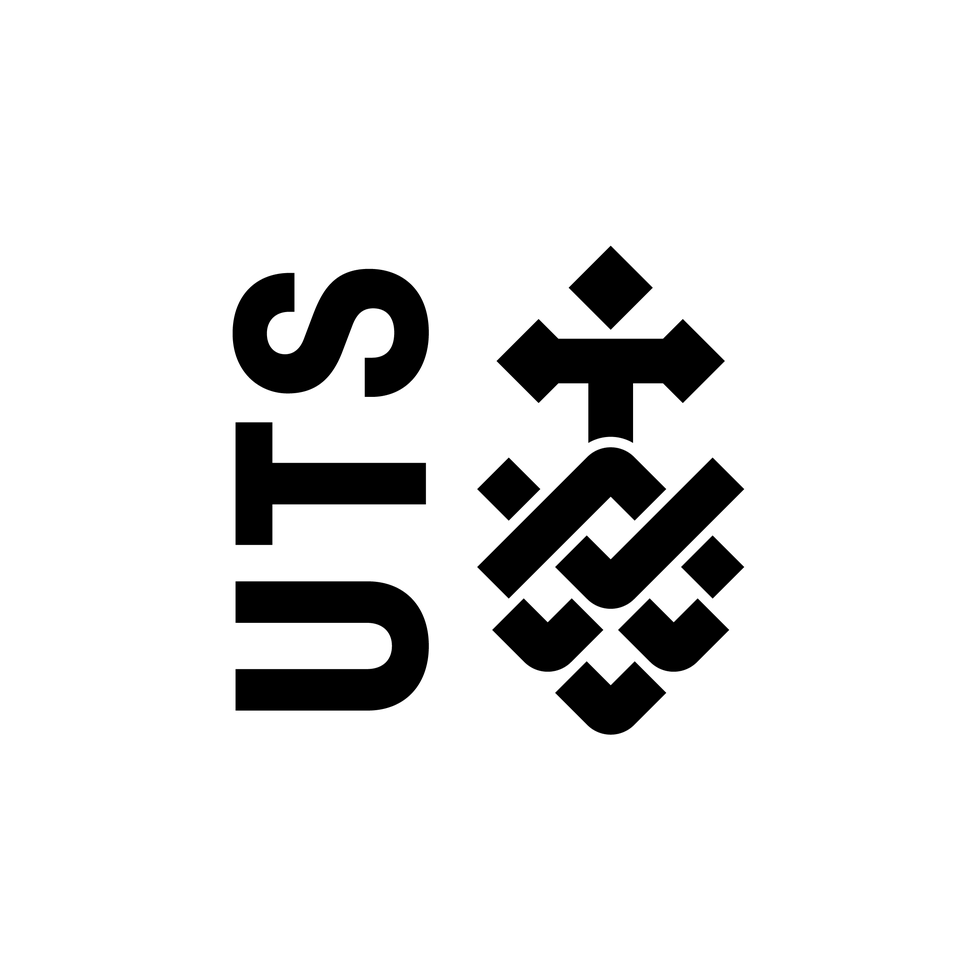

In [22]:
# Plot
fig = go.Figure()
colors = px.colors.qualitative.Pastel

# Base line
fig.add_trace(go.Scatter(x=df_base["Frequency"], y=df_base["Spectrum"], 
                        name="Baseline"))


# Signal returns
for i, d in enumerate(new_signals):
    fig.add_trace(go.Scatter(x=d["Frequency"], 
                             y=d["Spectrum"], 
                             line=dict(dash="dot", color=colors[i+1]),
                             name=d["Signal"][0]))
    
    
# Mark RTN Up/Down
if rtn_up:
    fig.add_vrect(x0=rtn_up[0], x1=rtn_up[1], line_width=0, fillcolor="#5FF0EB", opacity=0.2, 
                 annotation_text="RTN Up", annotation_position="top left")
    fig.add_vrect(x0=rtn_down[0], x1=rtn_down[1], line_width=0, fillcolor="#5FF0EB", opacity=0.2, 
                 annotation_text="RTN Down", annotation_position="top left")


# Formatting
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor="#EAF2F2", zeroline=True, zerolinecolor="slategrey")
fig.update_layout(plot_bgcolor="#FFFFFF", 
                  legend=dict(orientation="h",
                              yanchor="bottom",
                              y=1,
                              xanchor="right",
                              x=1),
                  title=dict(text="Signal Comparison",
                             x=0,
                             font=dict(size=20),
                             xanchor="left",
                             yanchor="top"),
                  xaxis_title="Frequency [Hz]", yaxis_title="Power [$\mu V^2$/Hz]")

# Add image
logo = uts_logo()
fig.add_layout_image(dict(source=logo,
                          xref="paper", yref="paper",
                          x=1.1, y=0.9,
                          sizex=0.3, sizey=0.3,
                          xanchor="right", yanchor="bottom")
                     )


fig.show()